In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import spatial
import pickle
import numpy as np
import numba as nb
import polars as pl

## First idea

In [2]:
#os.chdir("prog2-2024-c2-barab")

In [2]:
df = pd.read_csv("solution-1/input.csv")
query_df = pd.read_csv("solution-1/query.csv")

<Axes: ylabel='Density'>

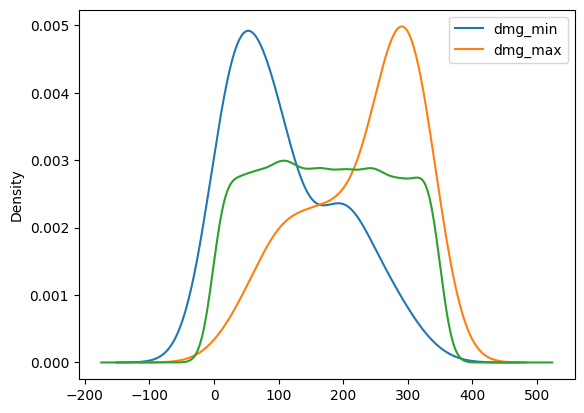

In [3]:
query_df[["dmg_min","dmg_max"]].plot.kde()
df["dmg"].plot.kde()

In [5]:
#Preproc
for dt in df["dmg_type"].unique():
    #print(dt)
    tree = spatial.cKDTree(df.loc[(df["dmg_type"] == dt),["x","y"]])
    with open("notebook_folder/tree_{}.pkl".format(dt),"wb") as file:
        pickle.dump(tree, file)
    """
    out_df = df.loc[(df["dmg_type"] == dt),["x","y","dmg"]]
    with open("notebook_folder/data_{}.pkl".format(dt),"wb") as file:
        pickle.dump(out_df, file)
    """
# Should this be sorted?
df[["x","y","dmg","dmg_type"]].to_pickle("notebook_folder/input.pkl")
with open("notebook_folder/dtypes.npy","wb") as file:
    np.save(file,df["dmg_type"].unique())
    



In [6]:
#Compute load
with open("notebook_folder/dtypes.npy","rb") as file:
    dtypes = np.load(file,allow_pickle=True)
for dt in dtypes:
    globals()["tree_" + dt] = pickle.load(open("notebook_folder/tree_{}.pkl".format(dt),"rb"))
    #globals()["df_" + dt] = pickle.load(open("notebook_folder/data_{}.pkl".format(dt),"rb"))
df_i = pd.read_pickle("notebook_folder/input.pkl")

  

In [7]:
# check functions
@nb.njit
def check_numbers_between_numba(lst, min_val, max_val):
    for num in lst:
        if min_val <= num <= max_val:
            return True
    return False

@nb.njit()
def count_numbers_between_numba(list,min_val,max_val):
    return_num = 0
    for num in list:
        if min_val <= num <= max_val:
            return_num += 1
    return return_num


In [25]:
# Compute calculate with threshold check
#Probably can be parallelize
out_df = pd.DataFrame()
counter_df = pd.DataFrame()
counter_list = []
range_list = []
for dt in dtypes:
    dmg_list = []
    
    temp_dmgs = df_i.loc[(df_i["dmg_type"] == dt),["dmg"]].to_numpy()
    for idx, row in query_df.iterrows():
        #print("current id:",idx)
        #pot_sol_num = count_numbers_between_numba(temp_dmgs,row["dmg_min"],row["dmg_max"])
        if check_numbers_between_numba(temp_dmgs,row["dmg_min"], row["dmg_max"]):
            counter = 1
            if row["dmg_max"] - row["dmg_min"] > 40:
                
                while True:
                    if counter == 1:
                        index = globals()["tree_" + dt].query(row[["x","y"]])[1]
                    else:
                        index = globals()["tree_" + dt].query(row[["x","y"]],k=counter)[1][-1]
                    if (temp_dmgs[index] >= row["dmg_min"]) & (temp_dmgs[index] <= row["dmg_max"]):
                        dmg_list.append(temp_dmgs[index])
                        break
                    else:
                        counter += 1
            else:
                sub_df = df_i.loc[
                    (df_i["dmg_type"] == dt)
                    & (df_i["dmg"] >= row["dmg_min"])
                    & (df_i["dmg"] <= row["dmg_max"]),
                    ["x", "y", "dmg"],
                ]
                diffs = ((sub_df[["x", "y"]] - row) ** 2).sum(axis=1)
                dmg_list.append(sub_df.iloc[diffs.argmin(), 2])
                
        else:
            dmg_list.append(0)
        counter_list.append(counter)
        range_list.append(row["dmg_max"]-row["dmg_min"])

    out_df[dt] = dmg_list

counter_df = counter_df.assign(
counter = counter_list,
range_v = range_list
)
            
        

In [4]:
# Original
df = pd.read_csv("solution-1/input.csv")
query_df = pd.read_csv("solution-1/query.csv")

damage_types = df["dmg_type"].unique()
out = []
for idx, row in query_df.iterrows():
    out_row = {}
    for dt in damage_types:
        sub_df = df.loc[
            (df["dmg_type"] == dt)
           & (df["dmg"] >= row["dmg_min"])
           & (df["dmg"] <= row["dmg_max"]),
            ["x", "y", "dmg"],
        ]
        if sub_df.empty:
            out_row[dt] = 0
        else:
            diffs = ((sub_df[["x", "y"]] - row) ** 2).sum(axis=1)
            out_row[dt] = sub_df.iloc[diffs.argmin(), 2]
        #print(out_row)

    out.append(out_row)

original_out = pd.DataFrame(out)

In [23]:
%%timeit
# Compute calculate with threshold check
#Probably can be parallelize
out_df = pd.DataFrame()
counter_df = pd.DataFrame()
counter_list = []
range_list = []
for dt in dtypes:
    dmg_list = []
    
    temp_dmgs = df_i.loc[(df_i["dmg_type"] == dt),["dmg"]].to_numpy()
    for idx, row in query_df.iterrows():
        #print("current id:",idx)
        #pot_sol_num = count_numbers_between_numba(temp_dmgs,row["dmg_min"],row["dmg_max"])
        if check_numbers_between_numba(temp_dmgs,row["dmg_min"], row["dmg_max"]):
            counter = 1
            if row["dmg_max"] - row["dmg_min"] > 40:
                
                while True:
                    if counter == 1:
                        index = globals()["tree_" + dt].query(row[["x","y"]])[1]
                    else:
                        index = globals()["tree_" + dt].query(row[["x","y"]],k=counter)[1][-1]
                    if (temp_dmgs[index] >= row["dmg_min"]) & (temp_dmgs[index] <= row["dmg_max"]):
                        dmg_list.append(temp_dmgs[index])
                        break
                    else:
                        counter += 1
            else:
                sub_df = df_i.loc[
                    (df_i["dmg_type"] == dt)
                    & (df_i["dmg"] >= row["dmg_min"])
                    & (df_i["dmg"] <= row["dmg_max"]),
                    ["x", "y", "dmg"],
                ]
                diffs = ((sub_df[["x", "y"]] - row) ** 2).sum(axis=1)
                dmg_list.append(sub_df.iloc[diffs.argmin(), 2])
                
        else:
            dmg_list.append(0)
        counter_list.append(counter)
        range_list.append(row["dmg_max"]-row["dmg_min"])

    out_df[dt] = dmg_list

counter_df = counter_df.assign(
counter = counter_list,
range_v = range_list
)

311 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
df = pd.read_csv("solution-1/input.csv")
query_df = pd.read_csv("solution-1/query.csv")

damage_types = df["dmg_type"].unique()
out = []
for idx, row in query_df.iterrows():
    out_row = {}
    for dt in damage_types:
        sub_df = df.loc[
            (df["dmg_type"] == dt)
           & (df["dmg"] >= row["dmg_min"])
           & (df["dmg"] <= row["dmg_max"]),
            ["x", "y", "dmg"],
        ]
        if sub_df.empty:
            out_row[dt] = 0
        else:
            diffs = ((sub_df[["x", "y"]] - row) ** 2).sum(axis=1)
            out_row[dt] = sub_df.iloc[diffs.argmin(), 2]
        #print(out_row)

    out.append(out_row)

original_out = pd.DataFrame(out)

591 ms ± 47.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [70]:
%%timeit
# Compute calculate
#Probably can be parallelize
for dt in dtypes:
    temp_dmgs = df_i.loc[(df_i["dmg_type"] == dt),["dmg"]].to_numpy()
    for idx, row in query_df.iterrows():
        #print("current id:",idx)
        if check_numbers_between_numba(temp_dmgs,row["dmg_min"],row["dmg_max"]):
            pass
        else:
            pass

12.3 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Ez most a kis adaton gyorsabb, mint a baseline, felételezem a nagyon is, de nem lényegi a különbség, mert az input koordinátáit így is be kell olvasni sajnos

## Other ideas?

* Order the input df based upon the damage values
* Create an index df where each row is a damage value of input and the index from where it starts is the other column
* Load this and the if statements should check this
* The range check value (40 in our case) should change for larger data !! (smaller)
#### Do everything in polars !!!!

### Preproc

In [6]:
df = pd.read_csv("solution-1/input.csv")
for dt in df["dmg_type"].unique():
    #print(dt)
    tree = spatial.cKDTree(df.loc[(df["dmg_type"] == dt),["x","y"]])
    with open("notebook_folder/tree_{}.pkl".format(dt),"wb") as file:
        pickle.dump(tree, file)
    """
    out_df = df.loc[(df["dmg_type"] == dt),["x","y","dmg"]]
    with open("notebook_folder/data_{}.pkl".format(dt),"wb") as file:
        pickle.dump(out_df, file)
    """
    df.loc[(df["dmg_type"]== dt)].to_parquet("notebook_folder/input_data_{}.parquet".format(dt))
    df.sort_values("dmg").groupby("dmg").count().reset_index()[["dmg","x"]].to_parquet("notebook_folder/dmgs_{}.parquet".format(dt))

# Should this be sorted?
#df[["x","y","dmg","dmg_type"]].to_pickle("notebook_folder/input.pkl")
with open("notebook_folder/dtypes.npy","wb") as file:
    np.save(file,df["dmg_type"].unique())

In [10]:
###True preproc for treegasm solution
df = pd.read_csv("solution-1/input.csv")
tree_dict = {}
tree_dict1 = {}
for dt in df["dmg_type"].unique():
    inner_dict = {}
    for dmg in df["dmg"].unique():
                            
        tree = spatial.cKDTree(df.loc[(df["dmg_type"] == dt)&
                                      (df["dmg"] == dmg),["x","y"]])
        inner_dict[dmg] = tree

    tree = spatial.cKDTree(df.loc[(df["dmg_type"] == dt),["x","y"]])
    tree_dict[dt] = inner_dict
    tree_dict1[dt] = tree

with open("notebook_folder/smalltrees.pkl","wb") as file:
    pickle.dump(tree_dict,file)
with open("notebook_folder/bigtrees.pkl","wb") as file:
    pickle.dump(tree_dict1,file)

df.groupby(["dmg_type","dmg"]).count().reset_index()[["dmg_type","dmg"]].to_parquet("notebook_folder/compute_workfile.parquet")
with open("notebook_folder/dtypes.npy","wb") as file:
    np.save(file,df["dmg_type"].unique(),allow_pickle=True)
df[["dmg_type","dmg"]].to_parquet("notebook_folder/dmgs.parquet")


### Compute

### Treegasm 

In [11]:
# Load
query_df = pd.read_csv("solution-1/query.csv")
meta_df = pd.read_parquet("notebook_folder/compute_workfile.parquet")
with open("notebook_folder/dtypes.npy","rb") as file:
    dtypes = np.load(file,allow_pickle=True)

with open("notebook_folder/smalltrees.pkl","rb") as file:
    tree_dict = pickle.load(file)

with open("notebook_folder/bigtrees.pkl","rb") as file:
    tree_dict1 = pickle.load(file)

dmgs = pd.read_parquet("notebook_folder/dmgs.parquet")




In [13]:
out_df = pd.DataFrame()
for dt in dtypes:
    dmg_list = []
    temp_dmgs = dmgs.loc[(dmgs["dmg_type"]) == dt,"dmg"].to_numpy()
    for idx, row in query_df.iterrows():
        
        valid_dmgs = meta_df.loc[(meta_df["dmg_type"] == dt)&
                                    (meta_df["dmg"] >= row["dmg_min"])&
                                    (meta_df["dmg"]<=row["dmg_max"]),"dmg"]
        
        #print(type([valid_dmgs]))
        if len(valid_dmgs)==0:
            dmg_list.append(0)
        elif len(valid_dmgs)>0 and len(valid_dmgs)<30:

            dmg_list.append(valid_dmgs.iloc[pd.Series([tree_dict[dt][dmg].query(row[["x","y"]])[0] for
                dmg in valid_dmgs]).idxmin()])   
        else:
            counter = 1
            while True:
                    if counter == 1:
                        index = tree_dict1[dt].query(row[["x","y"]])[1]
                    else:
                        index = tree_dict1[dt].query(row[["x","y"]],k=counter)[1][-1]
                    if (temp_dmgs[index] >= row["dmg_min"]) & (temp_dmgs[index] <= row["dmg_max"]):
                        dmg_list.append(temp_dmgs[index])
                        break
                    else:
                        counter += 1
    out_df[dt] = dmg_list

In [18]:
%%timeit
out_df = pd.DataFrame()
for dt in dtypes:
    dmg_list = []
    temp_dmgs = dmgs.loc[(dmgs["dmg_type"]) == dt,"dmg"].to_numpy()
    for idx, row in query_df.iterrows():
        
        valid_dmgs = meta_df.loc[(meta_df["dmg_type"] == dt)&
                                    (meta_df["dmg"] >= row["dmg_min"])&
                                    (meta_df["dmg"]<=row["dmg_max"]),"dmg"]
        
        #print(type([valid_dmgs]))
        if len(valid_dmgs)==0:
            dmg_list.append(0)
        elif len(valid_dmgs)>0 and len(valid_dmgs)<3:

            dmg_list.append(valid_dmgs.iloc[pd.Series([tree_dict[dt][dmg].query(row[["x","y"]])[0] for
                dmg in valid_dmgs]).idxmin()])   
        else:
            counter = 1
            while True:
                    if counter == 1:
                        index = tree_dict1[dt].query(row[["x","y"]])[1]
                    else:
                        index = tree_dict1[dt].query(row[["x","y"]],k=counter)[1][-1]
                    if (temp_dmgs[index] >= row["dmg_min"]) & (temp_dmgs[index] <= row["dmg_max"]):
                        dmg_list.append(temp_dmgs[index])
                        break
                    else:
                        counter += 1
    out_df[dt] = dmg_list                    

215 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Treegasm with polars - Preproc is the same

In [14]:
# Load
query_df = pl.read_csv("solution-1/query.csv")
meta_df = pl.read_parquet("notebook_folder/compute_workfile.parquet")
with open("notebook_folder/dtypes.npy","rb") as file:
    dtypes = np.load(file,allow_pickle=True)

with open("notebook_folder/smalltrees.pkl","rb") as file:
    tree_dict = pickle.load(file)

with open("notebook_folder/bigtrees.pkl","rb") as file:
    tree_dict1 = pickle.load(file)

dmgs = pl.read_parquet("notebook_folder/dmgs.parquet")

In [24]:
#Compute - I leave it for now
out_df = pl.DataFrame()
for dt in dtypes:
    dmg_list = []
    temp_dmgs = dmgs.filter(dmgs["dmg_type"] == dt)["dmg"]
    for row in query_df.rows():
        print(row[3])
        valid_dmgs = meta_df.filter(
                                    (meta_df["dmg_type"] == dt)&
                                    (meta_df["dmg"] >= row[2])&
                                    (meta_df["dmg"] <= int(row[3])))


104.27745474661135


ValueError: invalid literal for int() with base 10: '104.27745474661135\r'

In [ ]:
        #print(type([valid_dmgs]))
        if len(valid_dmgs)==0:
            dmg_list.append(0)
        elif len(valid_dmgs)>0 and len(valid_dmgs)<20:

            dmg_list.append(valid_dmgs.iloc[pd.Series([tree_dict[dt][dmg].query(row[["x","y"]])[0] for
                dmg in valid_dmgs]).idxmin()])   
        else:
            counter = 1
            while True:
                    if counter == 1:
                        index = tree_dict1[dt].query(row[["x","y"]])[1]
                    else:
                        index = tree_dict1[dt].query(row[["x","y"]],k=counter)[1][-1]
                    if (temp_dmgs[index] >= row["dmg_min"]) & (temp_dmgs[index] <= row["dmg_max"]):
                        dmg_list.append(temp_dmgs[index])
                        break
                    else:
                        counter += 1
    out_df[dt] = dmg_list                    


### Other idea

In [9]:
# Load
query_df = pd.read_csv("solution-1/query.csv")
meta_df = pd.read_parquet("notebook_folder/compute_workfile.parquet")
with open("notebook_folder/dtypes.npy","rb") as file:
    dtypes = np.load(file,allow_pickle=True)
for dt in dtypes:
    globals()["input"]

In [10]:
#Compute
meta_df.head()

,dmg_type,dmg
0,acid,0
1,acid,1
2,acid,2
3,acid,3
4,acid,4


In [51]:
meta_df.loc[(meta_df["dmg_type"] == dt)&
                                  (meta_df["dmg"] >= 100)&
                                  (meta_df["dmg"]<=200),"dmg"]

1835    100
1836    101
1837    102
1838    103
1839    104
       ... 
1929    196
1930    197
1931    198
1932    199
1933    200
Name: dmg, Length: 99, dtype: int64